## Testing and learning pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchinfo import summary

In [2]:
# check for gpu
print(torch.backends.mps.is_available())  # Should return True if MPS (Metal Performance Shaders) is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

True


In [3]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [4]:
# Define a fully connected neural network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Initialize the model
model = MLP().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming 'model' is your PyTorch model
summary(model, input_size=(1, 1, 28, 28), device=device)  

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Linear: 1-1                            [1, 256]                  200,960
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 128]                  32,896
├─ReLU: 1-4                              [1, 128]                  --
├─Linear: 1-5                            [1, 10]                   1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.94
Estimated Total Size (MB): 0.95

In [6]:
# Training function
def train(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation loss and accuracy
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(test_loader)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Testing function
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [7]:
# Visualization function for loss and accuracy curves
def plot_training_curves(history):
    """Plot loss and accuracy curves from training history."""
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    
    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    
    plt.show()

# Confusion Matrix visualization
def plot_confusion_matrix(model, loader, classes):
    """Plot the confusion matrix for model predictions."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/5 - Train Loss: 0.2277, Train Acc: 0.9315, Val Loss: 0.1156, Val Acc: 0.9644
Epoch 2/5 - Train Loss: 0.0944, Train Acc: 0.9709, Val Loss: 0.0982, Val Acc: 0.9697
Epoch 3/5 - Train Loss: 0.0656, Train Acc: 0.9792, Val Loss: 0.0737, Val Acc: 0.9783
Epoch 4/5 - Train Loss: 0.0507, Train Acc: 0.9833, Val Loss: 0.0748, Val Acc: 0.9768
Epoch 5/5 - Train Loss: 0.0390, Train Acc: 0.9872, Val Loss: 0.0940, Val Acc: 0.9717


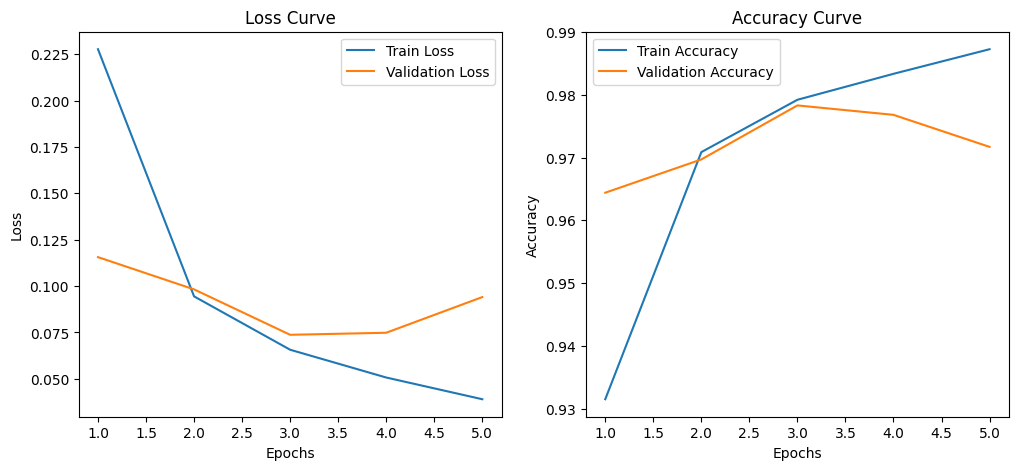

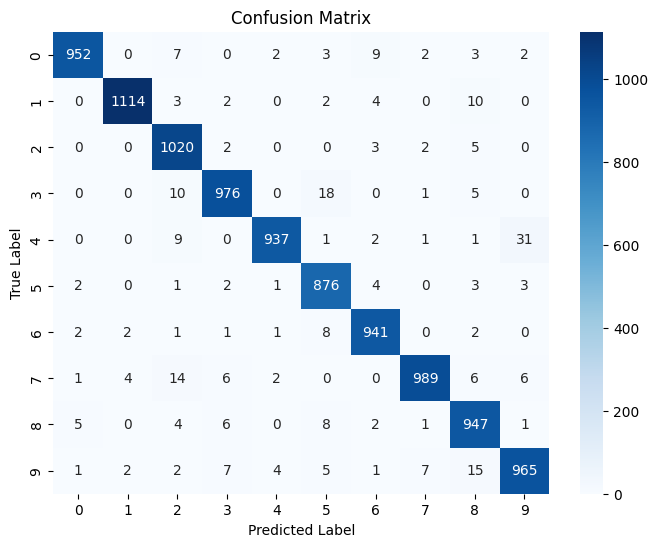

In [8]:
history = train(model, train_loader, test_loader, criterion, optimizer, epochs=5)
plot_training_curves(history)
plot_confusion_matrix(model, test_loader, classes=[str(i) for i in range(10)])